Let's see the dependency of USDRUB and BRENT in historical data. We will work with 7-day returns (TERM=7)

In [1]:
TERM = 7 # 7 days means that we estimate 7-day returns and later we will model 7-day returns via copulas

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

end = '2022-01-01'
start = '2014-01-01'
get_px = lambda x: web.get_data_yahoo(x, start=start, end=end)['Adj Close']

yf.pdr_override()
symbols = ['BZ=F', 'USDRUB=X']

# raw adjusted close prices
initial_df = pd.DataFrame({sym:get_px(sym) for sym in symbols})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df = initial_df

# change the names of columns
df = df.rename(columns={"BZ=F": "BRENT", "USDRUB=X": "USDRUB"})

# Remove NaN values
df = df.dropna()

# Filter out outliers in data
df = df[(df > 10).all(1)]

df

,BRENT,USDRUB
Date,,
2014-01-02,107.779999,32.706001
2014-01-03,106.889999,33.095200
2014-01-06,106.730003,33.165001
2014-01-07,107.349998,33.143200
2014-01-08,107.150002,33.103199
...,...,...
2021-12-27,78.599998,73.610001
2021-12-28,78.940002,73.359001
2021-12-29,79.230003,73.667503


In [4]:
rets = df.iloc[::TERM]  # to calc TERM-day returns
rets = np.log(rets/rets.shift(1)).dropna()
rets

,BRENT,USDRUB
Date,,
2014-01-13,-0.009602,0.008570
2014-01-24,0.010530,0.032148
2014-02-04,-0.019658,0.038221
2014-02-13,0.027506,-0.016960
2014-02-26,0.007239,0.025561
...,...,...
2021-11-11,-0.022079,-0.004780
2021-11-22,-0.039004,0.031699
2021-12-02,-0.134500,0.009650


Let's calculate some statistics

In [5]:
N = len(rets)  # number of data points

brent = np.array(rets['BRENT'])
usdrub = np.array(rets['USDRUB'])
brent_and_usdrub = np.array([brent, usdrub]).T

brent_mean = brent.mean()
brent_min = brent.min()
brent_max = brent.max()
brent_vol = brent.std()

usdrub_mean = usdrub.mean()
usdrub_min = usdrub.min()
usdrub_max = usdrub.max()
usdrub_vol = usdrub.std()

mean = [brent_mean, usdrub_mean]
cov = rets.cov().to_numpy()[:2, :2]

From the mutual distribution below, we definitely can say that it's not Gaussian distribution because of fat tails

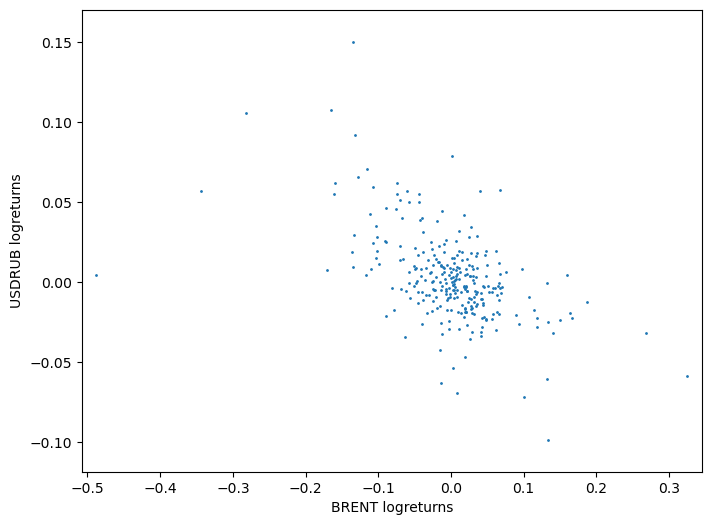

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.xlim([brent.min()-0.02, brent.max()+0.02])
plt.ylim([usdrub.min()-0.02, usdrub.max()+0.02])
plt.scatter(brent, usdrub, s=1)  # c=rets['Year'], cmap='inferno',    # cmap=hsv is good too
# plt.colorbar(label='Year')
plt.xlabel('BRENT logreturns')
plt.ylabel('USDRUB logreturns')
plt.show()

... and each univariate distribution is not Gaussian:

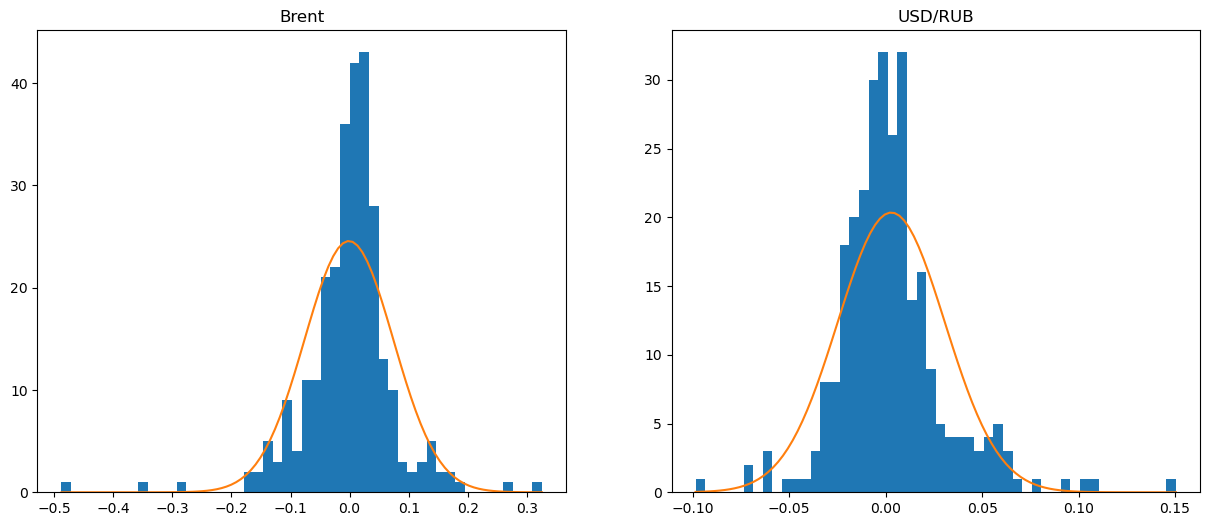

In [16]:
from scipy.stats import norm

N_hist = 50  # number of data intervals in histrogram

fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].hist(brent, N_hist)
ax[0].set_title("Brent")
# to create respective gaussian distribution
x = np.linspace(brent_min, brent_max, 100)
dx = (brent_max - brent_min) / N_hist
ax[0].plot(x, (N*dx) * norm.pdf(x, brent_mean, brent_vol))

ax[1].hist(usdrub, N_hist)
ax[1].set_title("USD/RUB")
# to create respective gaussian distribution
x = np.linspace(usdrub_min, usdrub_max, 100)
dx = (usdrub_max - usdrub_min) / N_hist
ax[1].plot(x, (N*dx) * norm.pdf(x, usdrub_mean, usdrub_vol))

plt.show() 

# Calibration to Multivariate Distributions and Copulas

In [8]:
def create_plot(x_gen, y_gen, x_real, y_real, title):
    __, ax = plt.subplots(1, 2, figsize=(15,6))

    xlim=[min(x_gen.min(), x_real.min())-0.02, max(x_gen.max(), x_real.max())+0.02]
    ylim=[min(y_gen.min(), y_real.min())-0.02, max(y_gen.max(), y_real.max())+0.02]

    ax[0].scatter(x_gen, y_gen, s=1)
    ax[0].set_title(title)
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel('BRENT logreturns')
    ax[0].set_ylabel('USDRUB logreturns')

    ax[1].scatter(x_real, y_real, s=1)
    ax[1].set_title("Real data")
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].set_xlabel('BRENT logreturns')
    ax[1].set_ylabel('USDRUB logreturns')
    plt.show() 

#### Calibrating to Multivariate Gaussian Distribution

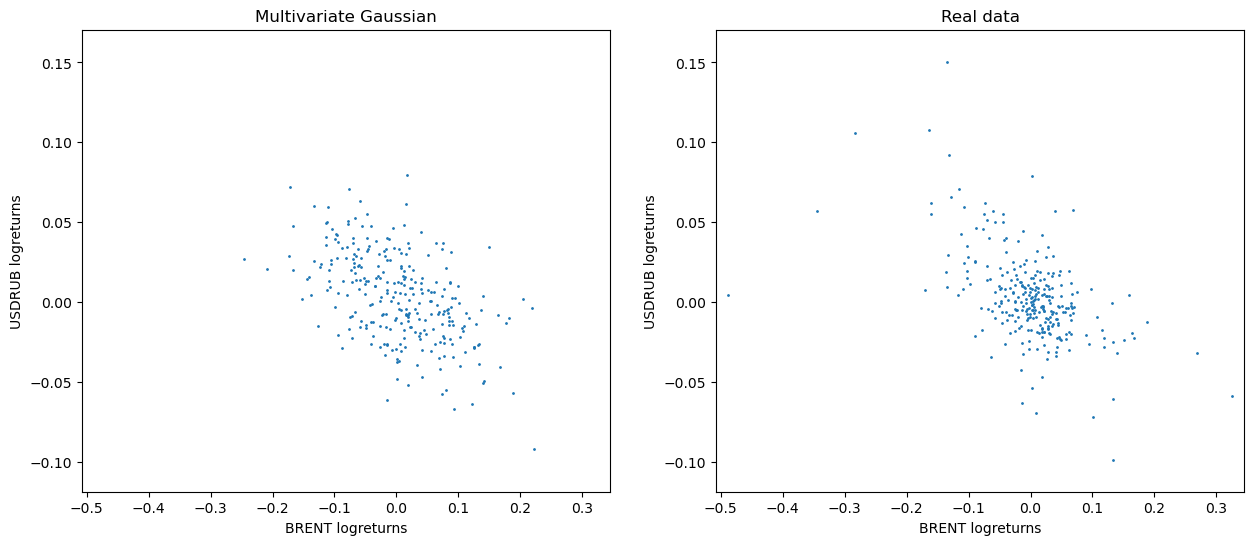

In [9]:
brent_mg, usdrub_mg = np.random.multivariate_normal(mean, cov, N).T

create_plot(brent_mg, usdrub_mg, brent, usdrub, 'Multivariate Gaussian')

As we can see, the real data has more fat tails and joint extreme events

## Multivariate t-student distribution

Let's find optimal parameters (loc, shape, degrees of freedom) of multivariate t-distribution maximizing log-likelihood.

In [10]:
from scipy.optimize import minimize
from scipy.stats import multivariate_t


def from_arr_to_matr(arr):
    return np.array([[arr[0], arr[1]], [arr[1], arr[2]]])


def calibrate_multivar_t(data):
    # We find params of multivariate t-distribution
    # by minimizing minus Log-likelihood function
    
    def log_likelihood(params, data):
        mu, cov, nu = params[:2], params[2:-1], params[-1]
        cov = from_arr_to_matr(cov)
        log_likelihood_value = multivariate_t.logpdf(data, loc=mu, shape=cov, df=nu).sum()
        return -log_likelihood_value


    # Initial guess for 6 parameters: 
    # mean vector (2 params), 
    # covariance matrix (3 params)
    # degrees of freedom (1 param)
    mean = data.mean(axis=0)
    cov = np.cov(data.T)
    initial_guess = [mean[0], mean[1], cov[0,0], cov[0,1], cov[1,1], 5.0]

    # Minimize the negative log-likelihood to estimate parameters
    result = minimize(log_likelihood, initial_guess, args=(data,), method='Nelder-Mead')

    # Extract the estimated parameters
    mu_estimated, cov_estimated, df_estimated = result.x[:2], from_arr_to_matr(result.x[2:-1]), result.x[-1]
    
    return df_estimated, mu_estimated, cov_estimated


# Calibrate our data to multivariate t-distribution
df_estimated, mu_estimated, cov_estimated = calibrate_multivar_t(brent_and_usdrub)

print("Estimated degrees of freedom (nu):", df_estimated)
print("Estimated mean vector (mu):", mu_estimated)
print("Estimated covariance matrix (sigma): \n", cov_estimated)

Estimated degrees of freedom (nu): 2.741666783895882
Estimated mean vector (mu): [4.59589229e-03 5.37073522e-05]
Estimated covariance matrix (sigma): 
 [[ 0.0018783  -0.00035477]
 [-0.00035477  0.00029381]]


Now let's apply these parameters to generate multivariate t-distribution data and compare them with real data

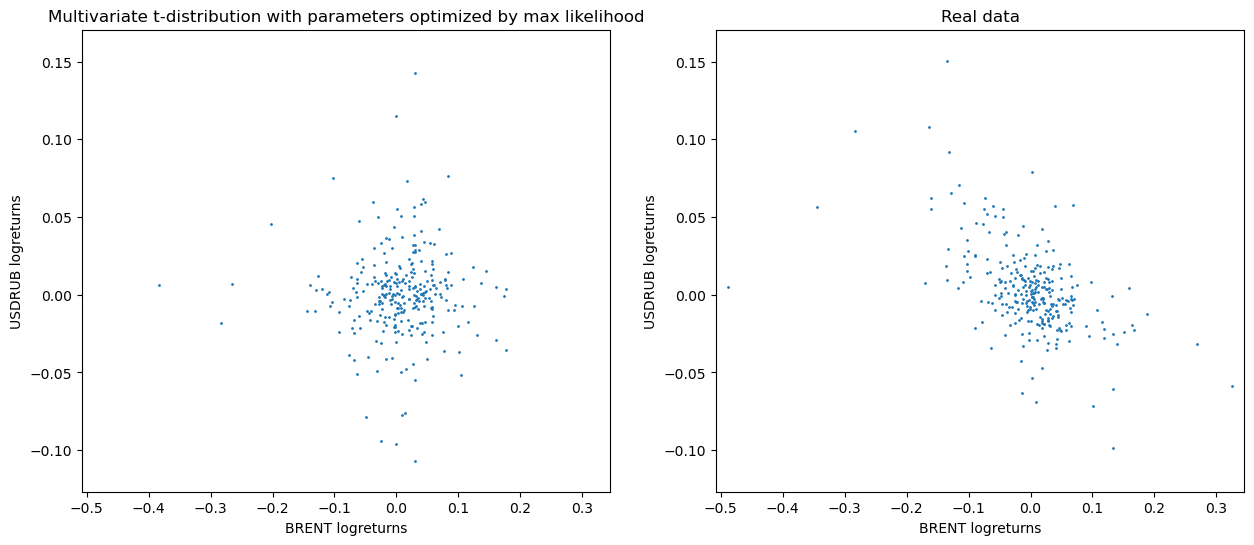

In [11]:
import numpy as np
from scipy.stats import multivariate_t
rv = multivariate_t(mu_estimated, cov_estimated, df=df_estimated)
brent_mt, usdrub_mt = rv.rvs(N).T[0], rv.rvs(N).T[1]  # generate N random variables

create_plot(brent_mt, usdrub_mt, brent, usdrub, 'Multivariate t-distribution with parameters optimized by max likelihood')

Not so many joint extreme values, especially in top part of the graph

## Gaussian copula with historical marginal distribution

It's not necessary to use multivariate gaussian distribution. We can just use multivariate gaussian copula but marginal (univariate) distribution we can take from real data

How to generate random variables from t-copula with historical marginal distributions?

1) We generate random variables x1, x2 from multivariate t-distribution

2) Calculate CDF $ u_1 = F_t(x1) $ and $ u_2 = F_t(x2) $ where $F_t$ is CDF for t-distribution

3) Having $u_1$ and $u_2$, we calculate the desired random variables $ breng_g = F_1^{-1}(u_1) $ and $ usdrub_g = F_2^{-1}(u_2) $ where $F_1$ and $F_2$ are real-data CDF's for brent and usdrub.

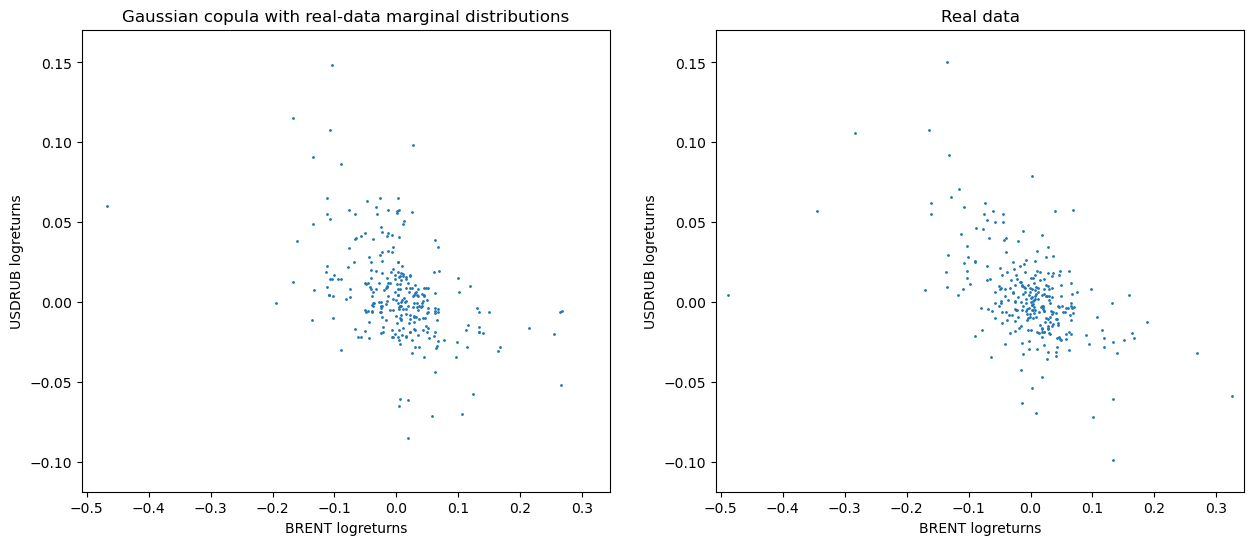

In [18]:
RHO = -0.5
N_ = N  # how much data point should we generate for our copula

x1, x2 = np.random.multivariate_normal([0, 0], [[1, RHO],[RHO,1]], N_).T
u1 = norm.cdf(x1)
u2 = norm.cdf(x2)
brent_gc = np.percentile(brent, q=u1*100)  # to sample univariate distributions from real data
usdrub_gc = np.percentile(usdrub, q=u2*100)  # q must be in [0,100]

create_plot(brent_gc, usdrub_gc, brent, usdrub, 'Gaussian copula with real-data marginal distributions')

Not so many joint extreme values

## t-copula with historical marginal distribution

It's not necessary to use multivariate t-distribution. We can just use multivariate t-copula but marginal (univariate) distributions for brent and USDRUB we can take from real data

How to generate random variables from t-copula with historical marginal distributions?

1) We generate random variables x1, x2 from multivariate t-distribution

2) Calculate CDF $ u_1 = F_t(x1) $ and $ u_2 = F_t(x2) $ where $F_t$ is CDF for t-distribution

3) Having $u_1$ and $u_2$, we calculate the desired random variables $ breng_g = F_1^{-1}(u_1) $ and $ usdrub_g = F_2^{-1}(u_2) $ where $F_1$ and $F_2$ are real-data CDF's for brent and usdrub.

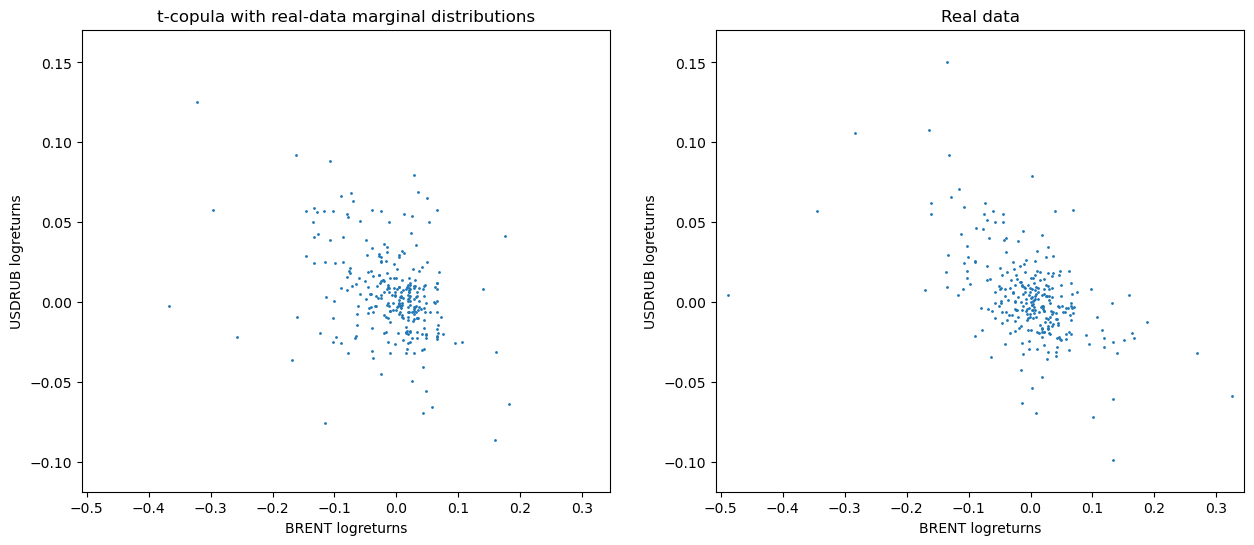

In [36]:
from scipy.stats import t
N_ = N  # how much data point should we generate for our copula

RHO = -0.4
DF = 2

x1, x2 = multivariate_t.rvs(loc=[0, 0], shape=[[1, RHO],[RHO,1]], df=DF, size=N_).T
u1 = t.cdf(x1, df=DF)
u2 = t.cdf(x2, df=DF)
brent_tc = np.percentile(brent, q=u1*100)  # q must be in [0,100]
usdrub_tc = np.percentile(usdrub, q=u2*100)

create_plot(brent_tc, usdrub_tc, brent, usdrub, 't-copula with real-data marginal distributions')

Cons of this method:

* symmetrical copula (in real data there are more extreme cases in the top of graph)

* because we sample univariate values from real data using percentile function, we can't get values large than max value or smaller than min value -> it's bad for generating/capturing new extreme points => need to model univariate values using some distribution.

## Clayton copula (=Archimedean, =explicit) with historical marginal distribution

From https://www.caee.utexas.edu/prof/bhat/abstracts/supp_material.pdf we have a plan how to generate random variables from Clayton copula with historical marginal distributions for brent and usdrub:

1) Generate $u_1$ ~ U(0, 1) and u ~ U(0, 1) independently

2) Set $ u = \frac{ F'(F^{-1}(u_1) + F^{-1}(u_2)) }{ F'(F^{-1}(u_1)) } $ and solve for $u_2$. The solution is $ u_2 =( ( u^{\frac{1}{1+\theta}} u_1 )^{-\theta} + 1 - u_1^{-\theta} )^{-\frac{1}{\theta}} $

3) Having $u_1$ and $u_2$, we calculate the desired random variables $ brent_g = F_1^{-1}(u_1) $ and $ usdrub_g = F_2^{-1}(u_2) $ where $F_1$ and $F_2$ are real-data CDF's for brent and usdrub.

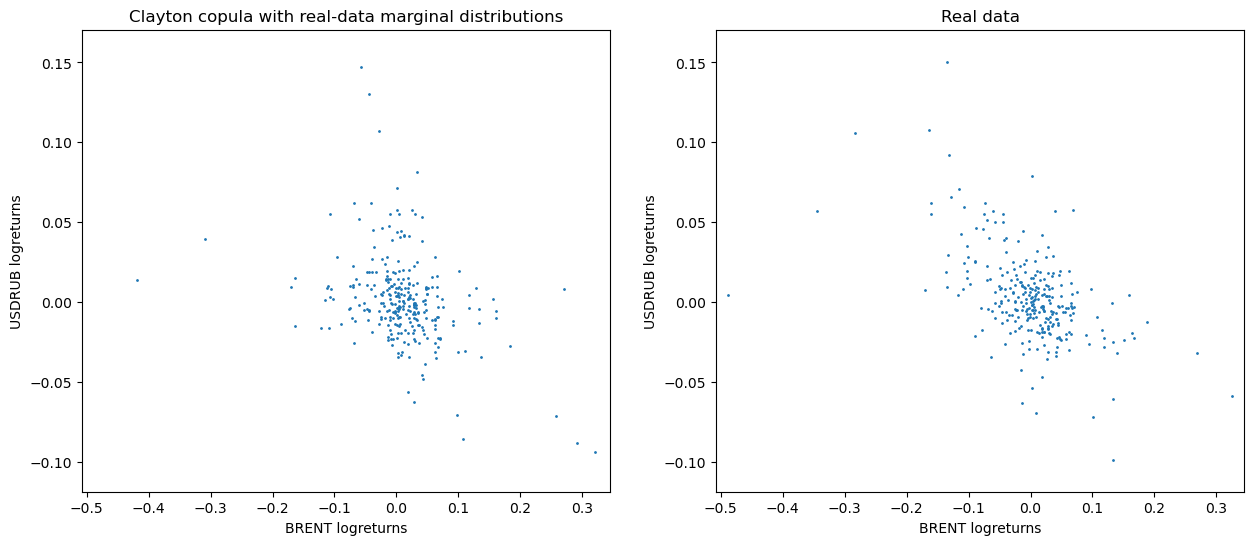

In [42]:
from scipy.stats import t
N_ = N  # how much data point should we generate for our copula

THETA = 0.5 # [0, +inf]
u1 = np.random.rand(N_)
u = np.random.rand(N_)
u2 = ( (u ** (1/(1+THETA)) * u1)**(-THETA) + 1 - u1**(-THETA) ) ** (-1/THETA)
brent_cc = np.percentile(brent, q=(1-u1)*100)  # q must be in [0,100]
usdrub_cc = np.percentile(usdrub, q=u2*100)

create_plot(brent_cc, usdrub_cc, brent, usdrub, 'Clayton copula with real-data marginal distributions')

Best model

Pros:

* Asymmetrical. For Clayton copula, we usually have joint extreme (usdrub-, brent+) events and almost no joint extreme (usdrub+, brent-) events

* Fat tails

Cons:

* because we sample univariate values from real data using percentile function, we can't get values large than max value or smaller than min value -> it's bad for generating/capturing new extreme points => need to model univariate values using some distribution.

## Gumbell copula (=Archimedean, =explicit) with historical marginal distribution

From https://www.caee.utexas.edu/prof/bhat/abstracts/supp_material.pdf we have a plan how to generate random variables from Gumbell copula with historical marginal distributions for brent and usdrub:

1) Generate two independent uniform variates $(v_1, v_2)$

2) Set $ w(1 - \frac{ ln(w) }{\theta} ) = v_2 $ and solve numerically for 0 < w < 1

3) Set $ u_1 = e^{v_1^{\frac{1}{\theta}} ln(w) } $ and $ u_2 = e^{(1-v_1)^{\frac{1}{\theta}} ln(w) } $

4) Having $u_1$ and $u_2$, we calculate the desired random variables $ brent_g = F_1^{-1}(u_1) $ and $ usdrub_g = F_2^{-1}(u_2) $ where $F_1$ and $F_2$ are real-data CDF's for brent and usdrub.

C:\Users\alexi\AppData\Local\Temp\ipykernel_5468\367603718.py:6: RuntimeWarning: invalid value encountered in log
  return ( w*(1 - np.log(w)/THETA)  - v2)**2


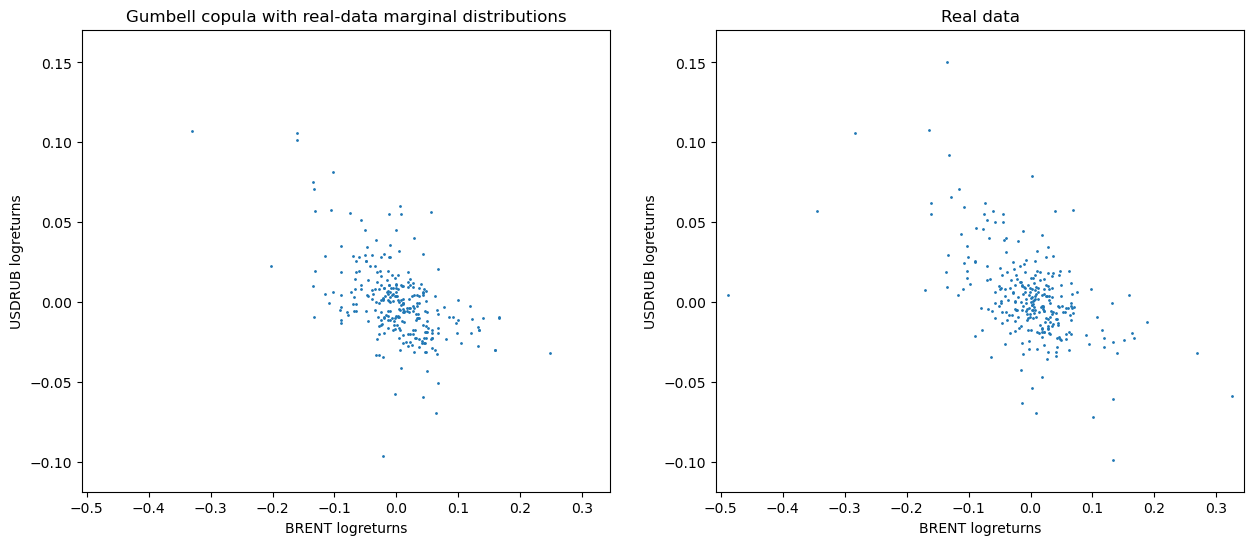

In [56]:
from scipy.stats import t
from scipy.optimize import fmin
N_ = N  # how much data point should we generate for our copula

def f(w, THETA, v2):
    return ( w*(1 - np.log(w)/THETA)  - v2)**2

THETA = 1.6  # [1, inf+]
v1 = np.random.rand(N_)
v2 = np.random.rand(N_)
# disp = 0 to not show information about optimization
w = np.array([fmin(f, 1, args=(THETA, v2_), disp=0)[0] for v2_ in v2])  # optimize one by one is faster
u1 = np.exp(v1**(1/THETA) * np.log(w))
u2 = np.exp((1-v1)**(1/THETA) * np.log(w))
brent_gumc = np.percentile(brent, q=(1-u1)*100)  # q must be in [0,100]
usdrub_gumc = np.percentile(usdrub, q=u2*100)

create_plot(brent_gumc, usdrub_gumc, brent, usdrub, 'Gumbell copula with real-data marginal distributions')